In [1]:
import pandas as pd
import os
import re
import glob
import nibabel as nib
import numpy as np
import tensorflow as tf
print(tf.__version__)

import random

import keras
from keras import backend as K
from keras.utils import np_utils
from keras.engine import Layer

from keras.layers import Input, Dense, Convolution1D, Reshape, Flatten, BatchNormalization, Lambda, Dropout, Activation
from keras.layers import Convolution3D, MaxPooling3D
from keras.models import Model, Sequential
from keras.models import model_from_json

from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image

import datetime
from itertools import compress
from scipy.ndimage import zoom
from matplotlib import pyplot as plt

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Show images
%matplotlib inline 

2.0.0


Using TensorFlow backend.


In [2]:
#tf.device('/gpu:1')
#tf.device('/device:GPU:0')
#tf.test.gpu_device_name()

In [3]:
dem = pd.read_table('/home/ubuntu/data/ds115_metadata/demographics.txt')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [4]:
sid_fixed = []

for i in dem['subcode']:
    tmp_str = re.sub('sub', 'sub-', i)
    tmp_str = re.sub('-00', '-0', tmp_str)
    
    if len(tmp_str) == 7 and tmp_str.split('-')[1][0] == '0':
        sid_fixed.append(re.sub('sub-0', 'sub-', tmp_str))
    else:
        sid_fixed.append(tmp_str)

print(sid_fixed)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40', 'sub-41', 'sub-42', 'sub-43', 'sub-44', 'sub-45', 'sub-46', 'sub-47', 'sub-48', 'sub-49', 'sub-50', 'sub-51', 'sub-52', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-59', 'sub-60', 'sub-61', 'sub-62', 'sub-63', 'sub-64', 'sub-65', 'sub-66', 'sub-67', 'sub-68', 'sub-69', 'sub-70', 'sub-71', 'sub-72', 'sub-73', 'sub-74', 'sub-75', 'sub-76', 'sub-77', 'sub-78', 'sub-79', 'sub-80', 'sub-81', 'sub-82', 'sub-83', 'sub-84', 'sub-85', 'sub-86', 'sub-87', 'sub-88', 'sub-89', 'sub-90', 'sub-91', 'sub-92', 'sub-93', 'sub-94', 'sub-95', 'sub-96', 'sub-97', 'sub-98', 'sub-99', 'sub-100'

In [5]:
dem['sid_fixed'] = sid_fixed

In [6]:
paths = []
for i in dem['sid_fixed']:
    paths.append(glob.glob('/home/ubuntu/data/ds000115_R2.0.0/' + i + '/anat/*.nii.gz'))

In [7]:
dem['t1_paths'] = paths

In [8]:
scz_t1_paths = dem[(dem['condit']=='SCZ') | (dem['condit']=='SCZ-SIB')]['t1_paths']
con_t1_paths = dem[(dem['condit']=='CON') | (dem['condit']=='CON-SIB')]['t1_paths']

In [9]:
print(len(scz_t1_paths))
print(len(con_t1_paths))

60
42


In [10]:
scz_t1_paths = [str(path) for path in scz_t1_paths]
con_t1_paths = [str(path) for path in con_t1_paths]

In [11]:
sz_labs = ["SZ"] * len(scz_t1_paths)
con_labs = ["CON"] * len(con_t1_paths)

In [12]:
# Function to jointly shuffle labels and paths to facilitate training and testing
def shuffle_xy(sz_labs, con_labs, scz_t1_paths, con_t1_paths):
    
    random.seed(4)
    
    # join labels and paths across diagnoses
    labs_cat = sz_labs + con_labs
    paths_cat = scz_t1_paths + con_t1_paths
    
    # jointly shuffle two lists
    mapIndexPosition = list(zip(labs_cat, paths_cat))
    random.shuffle(mapIndexPosition)
    labs_cat_shuff, paths_cat_shuff = zip(*mapIndexPosition)
    
    return labs_cat_shuff, paths_cat_shuff

labels_shuffled, paths_shuffled = shuffle_xy(sz_labs, con_labs, scz_t1_paths, con_t1_paths)

print(labels_shuffled[0:5])
print(paths_shuffled[0:5])

('CON', 'CON', 'CON', 'SZ', 'SZ')
("['/home/ubuntu/data/ds000115_R2.0.0/sub-43/anat/sub-43_T1w.nii.gz']", "['/home/ubuntu/data/ds000115_R2.0.0/sub-64/anat/sub-64_T1w.nii.gz']", "['/home/ubuntu/data/ds000115_R2.0.0/sub-56/anat/sub-56_T1w.nii.gz']", "['/home/ubuntu/data/ds000115_R2.0.0/sub-39/anat/sub-39_T1w.nii.gz']", "['/home/ubuntu/data/ds000115_R2.0.0/sub-02/anat/sub-02_T1w.nii.gz']")


In [13]:
# Drop 'null' cases
drop_idx=[i != '[]' for i in paths_shuffled]

paths_shuffled=list(compress(paths_shuffled, drop_idx))
labels_shuffled=list(compress(labels_shuffled, drop_idx))

assert len(paths_shuffled) == len(labels_shuffled)

In [14]:
def load_dataset():
    
    def reshape_image(img,x,y,z):
        resized=zoom(img, (1,x,y,z))
        return resized

    def load_mri(fid):
        # fix fid
        filepath = str(fid[2:-2])

        # load data
        im = nib.load(filepath)
        im = im.dataobj
        im = np.expand_dims(im, axis=0) # unsure if this is needed but feels more consistent to have dimension (n, z, x, y)
        
        im=reshape_image(im, .85, .78, .78)
        
        return im
    
    # load training data
    training_data = load_mri(paths_shuffled[0])
    
    for f in range(1,5):
        tmp_data = load_mri(paths_shuffled[f])
        training_data = np.vstack((training_data, tmp_data))
    
    training_labels = labels_shuffled[0:5]
    
    # load validation data
    validation_data = load_mri(paths_shuffled[6])
    
    for v in range(7,10):
        tmp_val_data = load_mri(paths_shuffled[v])
        validation_data = np.vstack((validation_data, tmp_val_data))
    
    validation_labels = labels_shuffled[6:10]
    
    return training_data, training_labels, validation_data, validation_labels    

In [15]:
training_data, training_labels, validation_data, validation_labels = load_dataset()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
# One-hot encode labels
def one_hot_encoder(labs):
    tmp=[int(i=='CON') for i in labs]
    return tf.keras.utils.to_categorical(tmp)

training_labels_ohe=one_hot_encoder(training_labels)
validation_labels_ohe=one_hot_encoder(validation_labels)

In [17]:
# Add channel? https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4
training_data=training_data.reshape(training_data.shape[0],training_data.shape[1],training_data.shape[2],training_data.shape[3],1)
validation_data=validation_data.reshape(validation_data.shape[0],validation_data.shape[1],validation_data.shape[2],validation_data.shape[3],1)

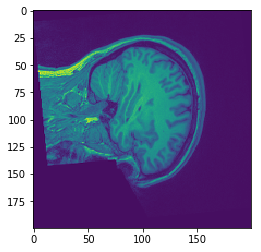

In [18]:
plt.imshow(training_data[3][100,:,:,0])

In [19]:
# Convert datasets to tensors for batch processing: https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/r2/get_started.ipynb#scrollTo=nnHx4DsMezy1
#train_tensor=tf.data.Dataset.from_tensor_slices((training_data, np.array(training_labels)))
#validation_tensor=tf.data.Dataset.from_tensor_slices((validation_data, np.array(validation_labels)))

train_tensor=tf.data.Dataset.from_tensor_slices((training_data, training_labels_ohe))
validation_tensor=tf.data.Dataset.from_tensor_slices((validation_data, validation_labels_ohe))

train_tensor=train_tensor.shuffle(5).batch(1)
validation_tensor=validation_tensor.shuffle(5).batch(1)

In [20]:
train_tensor

<BatchDataset shapes: ((None, 150, 200, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [21]:
### Going to need to downsample data before running this, otherwise get OOM error ###
def create_model():
    
    return tf.keras.models.Sequential([
        tf.keras.layers.Convolution3D(filters=16, kernel_size=(3,3,3), name='conv1', input_shape=(150,200,200,1), padding='valid'),
        #tf.keras.layers.Convolution3D(filters=32, kernel_size=(3,3,3), name='conv1', input_shape=(150,200,200,1), padding='valid'),
        tf.keras.layers.MaxPool3D(pool_size=(2,2,2), name='pool1'),
        tf.keras.layers.Convolution3D(filters=16, kernel_size=(3,3,3), name='conv2', padding='valid'),
        tf.keras.layers.MaxPool3D(pool_size=(2,2,2), name='pool2'),
        tf.keras.layers.Convolution3D(filters=16, kernel_size=(3,3,3), name='conv3', padding='valid'),
        tf.keras.layers.MaxPool3D(pool_size=(2,2,2), name='pool3'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, activation='relu', name='dense1'),
        tf.keras.layers.Dropout(rate=0.5, name='dropout1'),
        tf.keras.layers.Dense(2, activation='softmax', name='softmax')
    ])

model=create_model()

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# From: https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/r2/get_started.ipynb#scrollTo=WAQThq539CEJ
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [24]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
#train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
train_accuracy = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
#test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')
test_accuracy = tf.keras.metrics.CategoricalAccuracy('test_accuracy')

In [25]:
def train_step(model, optimizer, x_train, y_train):
  with tf.GradientTape() as tape:
    predictions = model(x_train, training=True)
    loss = loss_object(y_train, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_train, predictions)

def test_step(model, x_test, y_test):
  predictions = model(x_test)
  loss = loss_object(y_test, predictions)

  test_loss(loss)
  test_accuracy(y_test, predictions)

In [26]:
# Set up summary writers to write the summaries to disk in a different logs directory:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [27]:
# Troubleshooting dimensionality of tensor: https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4

model = create_model() # reset our model

EPOCHS = 10

for epoch in range(EPOCHS):
  for (x_train, y_train) in train_tensor:
    train_step(model, optimizer, x_train, y_train)
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  for (x_test, y_test) in validation_tensor:
    test_step(model, x_test, y_test)
  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
  
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

  # Reset metrics every epoch
  train_loss.reset_states()
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 3.223618984222412, Accuracy: 80.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 2, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 3, Loss: 9.674468994140625, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 4, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 5, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 6, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 7, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 8, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 9, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0
Epoch 10, Loss: 9.670857429504395, Accuracy: 40.0, Test Loss: 8.05904769897461, Test Accuracy: 50.0


#### To do: 
- scale up to larger sample size
- figure out how to run on GPU
- more sophisticated network architecture